In [79]:
import tensorflow as tf
import os #Navigate through file structures


In [80]:
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [81]:
# Avoiding Out of Memory Error by setting and limiting  GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [82]:
# Removing any dodgy images
import cv2 #Computer vision
import imghdr #Enables checking of different file extensions

In [83]:
#To check the folders present
os.listdir(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images')

['Parasitized', 'Uninfected']

In [84]:
image_extensions =['jpeg','jpg', 'bmp', 'png']
image_extensions[2]


'bmp'

In [85]:
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir,image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_extensions:
#                 print('Image not in extension list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))

In [86]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None) -> 'DatasetV2'>

In [87]:
import numpy as np
from matplotlib import pyplot as plt

In [88]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

In [89]:
#Building an image dataset
data = tf.keras.utils.image_dataset_from_directory(r'C:\Users\PC\Documents\Data-Science-Tasks\Malaria-ImageCLassification\cell_images')

Found 27558 files belonging to 2 classes.


In [90]:
data_iterator = data.as_numpy_iterator()

In [91]:
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x0000025C9CE8A720>)

In [92]:
#Gets another batch from the iterator
batch = data_iterator.next()
len(batch)

2

In [93]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [94]:
# Class 0 equals Parasatized
# Class 1 equals Uninfected
batch[1].max

<function ndarray.max>

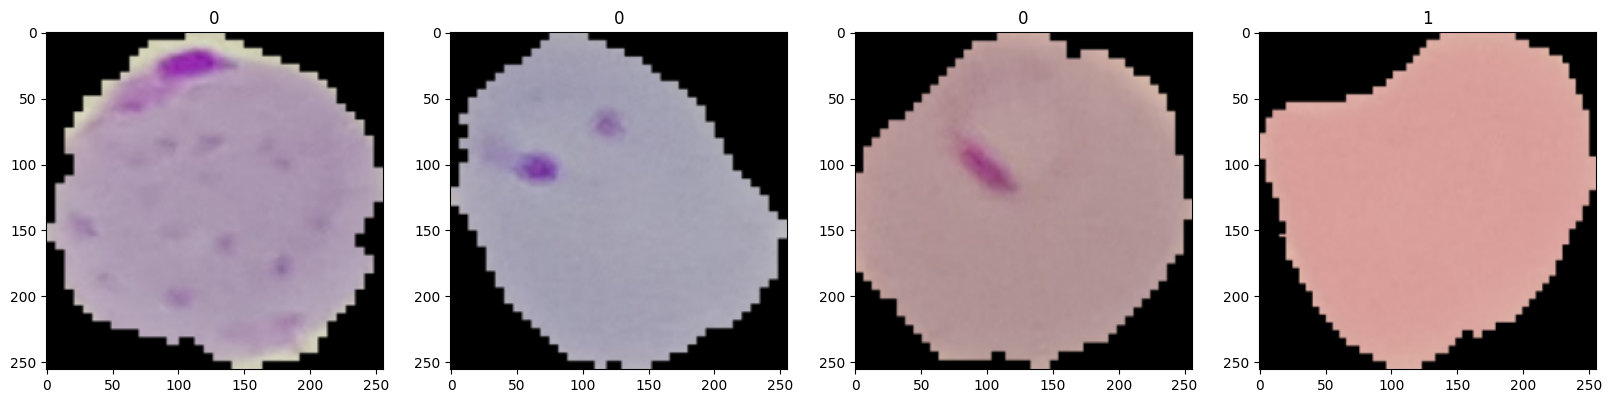

In [95]:
#Using matplotlib to plot out 4 images at the same time
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Pre processing Data

This section will involve scaling the image values to between 0 and 1 instead of 25,500 images.
This will help the Deep Learning Models generalize faster and produce better results.
Also, I will split the data into three sections to endure we dont overfit:
1. Training
2. Testing
3. Validation

In [96]:
# Scaling the Data
data = data.map(lambda x, y: (x/255, y))


In [97]:
scaled_iterator = data.as_numpy_iterator()

In [98]:
#The images are between 0 and 1
scaled_iterator.next()[1].max()

1

In [99]:
#862 Batches and each batch has 32 images. 862 * 32 = 27584 images
len(data)

862

In [100]:
#Establishing training data sizes, allocating data to each of the partitions

train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [101]:
train_size + val_size + test_size

862

In [102]:
train = data.take(train_size) 
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [103]:
len(train)

603

In [104]:
len(val)

172

In [105]:
len(test)

87

# Deep Model

Deep modelling using the Keras sequential model API 
Build a deep learning model

In [106]:
from tensorflow.keras.models import Sequential #deep learning classification
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout 

In [107]:
model = Sequential()

In [108]:
#
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [109]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Training the data

In [112]:
logdir='logs'

In [113]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [114]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 1066s 2s/step - accuracy: 0.7537 - loss: 0.4902 - val_accuracy: 0.9322 - val_loss: 0.1978
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 541s 897ms/step - accuracy: 0.9376 - loss: 0.1831 - val_accuracy: 0.9402 - val_loss: 0.1722
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 560s 928ms/step - accuracy: 0.9501 - loss: 0.1545 - val_accuracy: 0.9508 - val_loss: 0.1593
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 531s 879ms/step - accuracy: 0.9565 - loss: 0.1289 - val_accuracy: 0.9504 - val_loss: 0.1697
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 654s 1s/step - accuracy: 0.9644 - loss: 0.1016 - val_accuracy: 0.9559 - val_loss: 0.1632
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 583s 917ms/step - accuracy: 0.9702 - loss: 0.0854 - val_accuracy: 0.9529 - val_loss: 0.2090
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 509s 844ms/step - accuracy: 0.9781 - loss: 0.0654 - val_accuracy: 0.9482 - val_loss: 0.2109
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.9818 - loss: 0

In [ ]:
hist.history

Plot Perfomance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Accuracy metrics
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Evaluate Performance

Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy}')

Testing the data

In [ ]:
#use the cv2
img = cv2.imread('uninfectedsmear.jpg')
plt.imshow(img, cv2.COLOR_BGR2RGB)
plt.show()

In [ ]:
resize_image = tf.image.resize(img, (256, 256))
plt.imshow(resize_image.numpy().astype(int))
plt.show()

In [ ]:
np.expand_dims(resize_image, 0)

In [ ]:
#Predict whether a pap smear is Uninfected or Parasitized.
# 1 = Uninfected and 0 = Parasitized
yhat = model.predict(np.expand_dims(resize_image/255, 0))
yhat

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Uninfected')
else:
    print(f'Predicted class is Parasitized')

# Save the Model

Saving the model, that I may be able to reload it at a future date

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','malariapapsmear.h5'))

In [ ]:
new_model = load_model(os.path.join('models','malariapapsmear.h5'))

In [ ]:
yhat_new=new_model.predict(np.expand_dims(resize_image/255, 0))

In [ ]:
if yhat_new > 0.5:
    print(f'Predicted class is Uninfected')
else:
    print(f'Predicted class is Parasitized')